In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression

In [2]:
data = pd.read_csv('data/College.csv').dropna()
data

,Unnamed: 0,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
0,Abilene Christian University,Yes,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
1,Adelphi University,Yes,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
2,Adrian College,Yes,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54
3,Agnes Scott College,Yes,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59
4,Alaska Pacific University,Yes,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
772,Worcester State College,No,2197,1515,543,4,26,3089,2029,6797,3900,500,1200,60,60,21.0,14,4469,40
773,Xavier University,Yes,1959,1805,695,24,47,2849,1107,11520,4960,600,1250,73,75,13.3,31,9189,83
774,Xavier University of Louisiana,Yes,2097,1915,695,34,61,2793,166,6900,4200,617,781,67,75,14.4,20,8323,49
775,Yale University,Yes,10705,2453,1317,95,99,5217,83,19840,6510,630,2115,96,96,5.8,49,40386,99


In [3]:
# Preprocessing data to X, y
X = data.drop(columns='Unnamed: 0')
X = pd.get_dummies(X, columns=['Private'], drop_first=True).drop(columns='Apps')
y = data['Apps']

# Create train test set for both X, y to measure test error (mean squared error)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, shuffle=False, random_state=None)

## Linear model using OLS

In [27]:
# Create model & fit model with train set
lm = LinearRegression(normalize=True, fit_intercept=True)
lm.fit(X_train, y_train)

# Measure test error
lm_pred = lm.predict(X_test)
lm_mse = mean_squared_error(y_test, lm_pred)
lm_r2 = r2_score(y_test, lm_pred)
print("Test error of Linear model: {:,.0f},  R2: {:.4f}".format(lm_mse, lm_r2))

Test error of Linear model: 1,413,322,  R2: 0.9209


## Ridge regression & Lasso regression 

In [5]:
# Alphas range set-up
alphas = np.logspace(4, -3, 100)

In [6]:
# Run Ridge CV to calculate mse and identify best alpha
ridgecv = RidgeCV(alphas= alphas, normalize=True, store_cv_values=True).fit(X_train, y_train)
mse_ridge_cv = ridgecv.cv_values_.mean(axis=0)

# Best alpha
# ridgecv_op = RidgeCV(normalize=True, store_cv_values=True).fit(X_train, y_train)
optimal_alpha_ridge_cv = ridgecv.alpha_

# Best MSE
optimal_mse_ridge_cv = np.abs(ridgecv.best_score_)

In [7]:
# Run Lasso CV to calculate mse and identify best alpha
lassocv = LassoCV(alphas= alphas, normalize=True, cv=10).fit(X_train, y_train)
mse_lasso_cv = lassocv.mse_path_.mean(axis=1)

# Best alpha
# lassocv_op = LassoCV(normalize=True, cv=10).fit(X_train, y_train)
optimal_alpha_lasso_cv = lassocv.alpha_

# Best MSE
# optimal_model = LassoCV(alphas= [optimal_alpha_lasso_cv], normalize=True, cv=10).fit(X_train, y_train)
# optimal_mse_lasso_cv = np.abs(optimal_model.mse_path_.mean())
optimal_mse_lasso_cv = mse_lasso_cv.min()

In [8]:
# To be more visualize result of Ridge and Lasso in reducing number of predictors, create more function to get model result due to changes of alpha (lamda) and visualization

# Create Function result coefs Ridge or Lasso due to change of alpha (lamda)
def result_model(model, alphas, X, y):

    # Choose model
    if model == 'ridge':
        lm = Ridge(normalize= True)
    else:
        lm = Lasso(normalize= True)

    coefs = []

    # Run all model on range alphas
    for a in alphas:
        lm.set_params(alpha = a)
        lm.fit(X, y)
        coefs.append(lm.coef_)

    # Wrap in data frame with Collums names
    results = pd.DataFrame(coefs, columns=X.columns)
    
    return results

In [9]:
result_ridge = result_model('ridge', alphas, X_train, y_train)
result_lasso = result_model('lasso', alphas, X_train, y_train)

In [10]:
# Function visualize all coef of Result get above
def display_model(result_model, model, alphas, optimal_alpha, X, y):

    # Create threshold k where reduce significant coef beta
    if model == 'ridge':
        optimal_coef = Ridge(normalize=True).set_params(alpha = optimal_alpha).fit(X, y).coef_
    else:
        optimal_coef = Lasso(normalize=True).set_params(alpha = optimal_alpha).fit(X, y).coef_

    # Draw all feature coef of model
    for i in range(len(result_model.columns)):
        label = '{}  : {:.2f}'.format(result_model.columns[i], optimal_coef[i]) if np.abs(optimal_coef[i])> 0.05 else ''
        plt.plot(alphas, result_model.iloc[:,i], linewidth=3, label=label)

    # Draw a vertical line at threshold k
    plt.axvline(x=optimal_alpha, linestyle='--', linewidth=2, label='Optimal alpha : {:.4f}'.format(optimal_alpha))

    # Scale in log for easier to see, set x,ylabel, legend
    plt.xscale('log')
    plt.xlabel('alpha')
    plt.ylabel('Standardized Coef')
    plt.legend()

In [11]:
# Function display mse of model for easier to see range set alphas and optimal point good or not
def display_mse(mse_result, alphas, optimal_alpha=0, optimal_mse=0, scale_display='ticks'):

    # Plot MSE line
    plt.plot(alphas, mse_result, label='MSE')

    # Plot Min point
    plt.scatter(alphas[mse_result.argmin()], mse_result.min(), label='Min MSE: {:,.0f} at alpha: {:.4f}'.format(mse_result.min(), alphas[mse_result.argmin()]))
    
    # Plot Optimal point
    if optimal_alpha != 0:
        plt.scatter(optimal_alpha, optimal_mse, label='Optimal MSE: {:,.0f} at alpha: {:.4f}'.format(optimal_mse, optimal_alpha))

    if scale_display == 'log':      
        plt.xscale('log')
    if scale_display == 'ticks':
        plt.xticks(alphas)
    
    plt.xlabel('alpha')
    plt.ylabel('Mean Squared Error')
    plt.legend()

In [12]:
# Function display number predictors when change alpha (lambda)
def display_number_predictors_by_alpha(result_model, alphas, optimal_alpha):

    # Calculate number predictors follow by changes of alpha
    number_predictors = result_model.astype('bool').sum(axis=1)

    # Plot line, and optimal alpha
    plt.plot(alphas, number_predictors, label='Number Predictors')
    plt.axvline(x=optimal_alpha, linestyle='--', linewidth=2, label='Optimal alpha : {:.4f}'.format(optimal_alpha))

    plt.xscale('log')
    plt.yticks(np.arange(0,len(result_model.columns)+1))
    plt.legend()

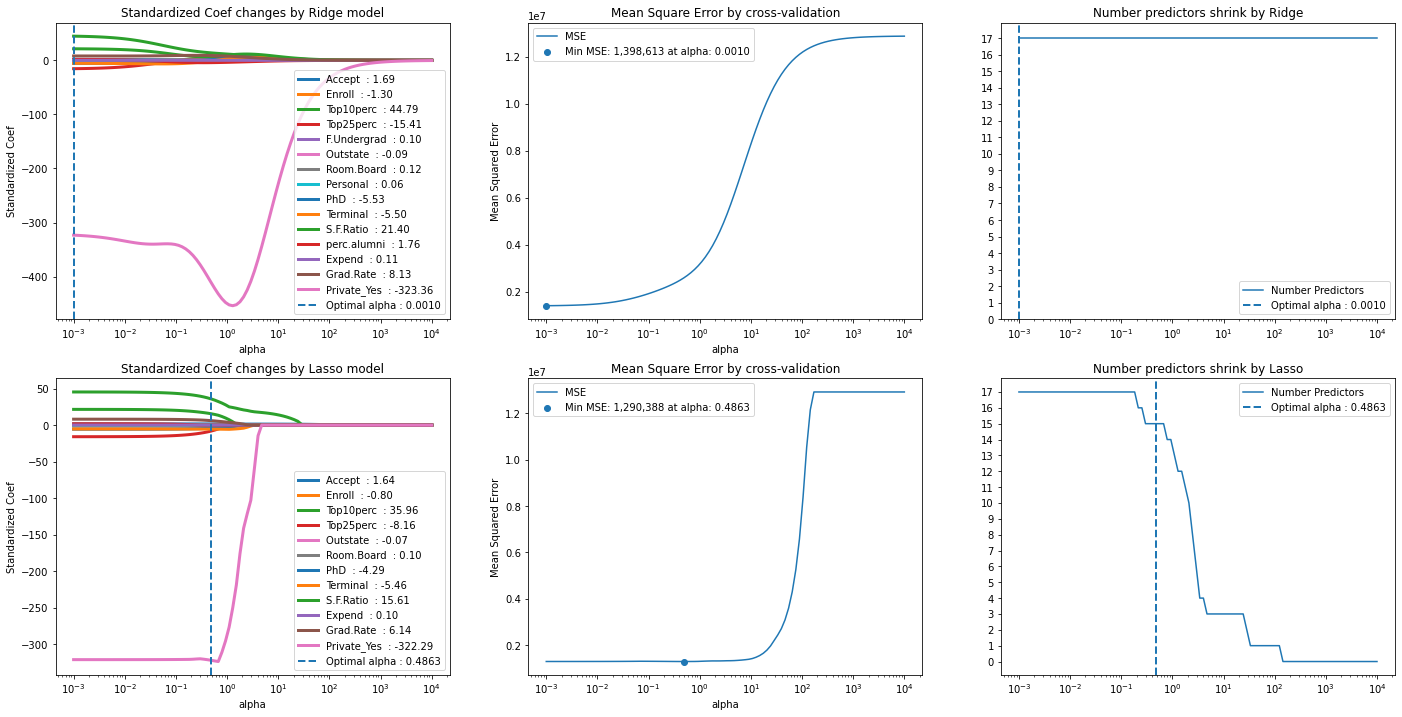

In [13]:
plt.figure(figsize=(24,12))

plot_1 = plt.subplot(2,3,1)
display_model(result_ridge, 'ridge', alphas, optimal_alpha_ridge_cv, X_train, y_train)
plt.title('Standardized Coef changes by Ridge model')

plot_2 = plt.subplot(2,3,2)
display_mse(mse_ridge_cv, alphas, scale_display='log')
plt.title('Mean Square Error by cross-validation')

plot_3 = plt.subplot(2,3,3)
display_number_predictors_by_alpha(result_ridge, alphas, optimal_alpha_ridge_cv)
plt.title('Number predictors shrink by Ridge')

plot_4 = plt.subplot(2,3,4)
display_model(result_lasso, 'lasso', alphas, optimal_alpha_lasso_cv, X_train, y_train)
plt.title('Standardized Coef changes by Lasso model')

plot_5 = plt.subplot(2,3,5)
display_mse(mse_lasso_cv, alphas, scale_display='log')
plt.title('Mean Square Error by cross-validation')

plot_6 = plt.subplot(2,3,6)
display_number_predictors_by_alpha(result_lasso, alphas, optimal_alpha_lasso_cv)
plt.title('Number predictors shrink by Lasso')

plt.show()

In [29]:
# Fit model Ridge with optimal alpha
ridgecv_op = RidgeCV(alphas = [optimal_alpha_ridge_cv], normalize=True, store_cv_values=True).fit(X_train, y_train)
ridgecv_op_pred = ridgecv_op.predict(X_test)

# Calculate test error Ridge
ridge_mse = mean_squared_error(y_test, ridgecv_op_pred)
ridge_r2 = r2_score(y_test, ridgecv_op_pred)
print("Test error of Ridge model: {:,.0f},  R2: {:.4f}".format(ridge_mse, ridge_r2))

Test error of Ridge model: 1,401,410,  R2: 0.9215


In [30]:
# Fit model Lasso with optimal alpha
lassocv_op = LassoCV(alphas= [optimal_alpha_lasso_cv], normalize=True, cv=10).fit(X_train, y_train)
lassocv_op_pred = lassocv_op.predict(X_test)
lassocv_op_num_predictors = np.sum(lassocv_op.coef_ != 0)

# Calculate test error Ridge
lasso_mse = mean_squared_error(y_test, lassocv_op_pred)
lasso_r2 = r2_score(y_test, lassocv_op_pred)
print("Test error of Lasso model: {:,.0f},  R2: {:.4f},  number predictors: {}".format(lasso_mse, lasso_r2, lassocv_op_num_predictors))

Test error of Lasso model: 1,359,130,  R2: 0.9239,  number predictors: 15


## Principal Components Regression - PCR

In [16]:
mse_PCR = pd.Series([])

# Proccess Linear regression for each n principal components
for i in range(1,len(X.columns)+1):
    
    # Create pca with i components
    pca = PCA(n_components=i)
    P_current = pd.DataFrame(pca.fit_transform(X))

    # Create train-test on K-folds method, train data on principal components
    cv = KFold(n_splits=10, random_state=None, shuffle=False)
    
    # Create Linear OLS func
    lm = LinearRegression()
    
    # Short way to create mse array of all 10-Folds is using cross_val_score
    score = cross_val_score(lm, P_current, y, cv=cv, scoring='neg_mean_squared_error')

    # Add result to mse mean
    mse_PCR.loc[i] = np.mean(np.abs(score))

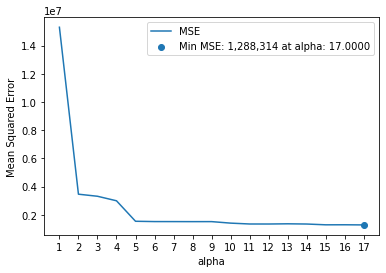

In [17]:
display_mse(mse_PCR, mse_PCR.index)

In [31]:
# Choose number principal components for PCR is 17
# Result will be same like OLS
n_pca = 17
pca = PCA(n_components=n_pca)
P_current = pd.DataFrame(pca.fit_transform(X))

P_train, P_test = train_test_split(P_current, train_size = 0.7, shuffle=False, random_state=None)

# Fit model
lm_p = LinearRegression(normalize=True, fit_intercept=True)
lm_p.fit(P_train, y_train)

# Calculate mse
lm_p_pred = lm_p.predict(P_test)
lm_p_mse = mean_squared_error(y_test, lm_p_pred)
lm_p_r2 = r2_score(y_test, lm_p_pred)
print("Test error of Principal Components Regression model: {:,.0f},  R2: {:.4f},  number components: {}".format(lm_p_mse, lm_p_r2, n_pca))

Test error of Principal Components Regression model: 1,413,322,  R2: 0.9209,  number components: 17


## Partial Least Squared - PLS

In [19]:
mse_PLS = pd.Series([])

# Proccess PLS for each n components
for i in range(1,len(X.columns)+1):
    
    # Create PLS function
    pls = PLSRegression(n_components=i)

    # Create train-test on K-folds method, train data on principal components
    cv = KFold(n_splits=10, random_state=None, shuffle=False)
    
    # Short way to create mse array of all 10-Folds is using cross_val_score
    score = cross_val_score(pls, X, y, cv=cv, scoring='neg_mean_squared_error')

    # Add result to mse mean
    mse_PLS.loc[i] = np.mean(np.abs(score))

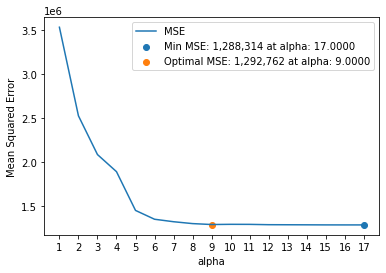

In [20]:
display_mse(mse_PLS, mse_PLS.index, 9, mse_PLS.loc[9])

In [32]:
# Choose n = 9 for PLS, seem good amount of predictors be reduced
n_pls = 9

pls = PLSRegression(n_components=n_pls)

# Fit model
pls.fit(X_train, y_train)

# Calculate mse
pls_pred = pls.predict(X_test)
pls_mse = mean_squared_error(y_test, pls_pred)
pls_r2 = r2_score(y_test, pls_pred)
print("Test error of Partial Least Squared model: {:,.0f},  R2: {:.4f},  number components: {}".format(pls_mse, pls_r2, n_pls))

Test error of Partial Least Squared model: 1,362,040,  R2: 0.9237,  number components: 9


## Summary all results

In [34]:
print("Test error of Linear model: {:,.0f},  R2: {:.4f}".format(lm_mse, lm_r2))
print("Test error of Ridge model : {:,.0f},  R2: {:.4f}".format(ridge_mse, ridge_r2))
print("Test error of Lasso model : {:,.0f},  R2: {:.4f},  number predictors: {}".format(lasso_mse, lasso_r2, lassocv_op_num_predictors))
print("Test error of PCR model   : {:,.0f},  R2: {:.4f},  number components: {}".format(lm_p_mse, lm_p_r2, n_pca))
print("Test error of PLS model   : {:,.0f},  R2: {:.4f},  number components: {}".format(pls_mse, pls_r2, n_pls))

Test error of Linear model: 1,413,322,  R2: 0.9209
Test error of Ridge model : 1,401,410,  R2: 0.9215
Test error of Lasso model : 1,359,130,  R2: 0.9239,  number predictors: 15
Test error of PCR model   : 1,413,322,  R2: 0.9209,  number components: 17
Test error of PLS model   : 1,362,040,  R2: 0.9237,  number components: 9


In [23]:
# Best model have least test error is Lasso, also reduced predictors and easier to interpret than other model PCR, PLS